In [ ]:
!pip install pmdarima

In [11]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import re
import math
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error ,mean_absolute_error, mean_absolute_percentage_error
from pmdarima.arima import ADFTest
plt.rcParams.update({'figure.figsize':(14,5), 'figure.dpi':70, 'axes.grid':True})

In [12]:
#Preprocessing data
df = pd.read_csv("XAUUSD.csv")
df = df.rename(columns ={"XAUUSD Historical Data" : "Date", "Unnamed: 1": "Open", "Unnamed: 2": "High",
                         "Unnamed: 3": "Low", "Unnamed: 4": "Close", "Unnamed: 5": "Change(Pips)", 
                         "Unnamed: 6": "Change(%)"})
df.drop(0 ,axis=0, inplace=True)
df = df.reset_index(drop = True)
df = df[::-1]
df = df.astype({'Open':'float','High':'float','Low':'float','Close':'float','Change(Pips)':'float',
                'Change(%)':'float'})

In [13]:
#Add ds column in datetime format
df['year']=df["Date"].apply(lambda x: re.search(r"^([\w]*)/([\w]*)/([\w]*)",x)[3])
df['day']=df["Date"].apply(lambda x: re.search(r"^([\w]*)/([\w]*)/",x)[2])
df['month']=df["Date"].apply(lambda x: re.search(r"^([\w]*)/",x)[1])
df['ds'] = pd.DatetimeIndex(df['year']+'-'+df['month']+'-'+df['day'])
#Remove unusable column and change index
df.drop(['Date','year','month','day','Change(Pips)','Change(%)','High','Low','Open'], axis=1, inplace=True) #Change(Pips),Change(%) could drop from dataframe
df = df.set_index('ds')

In [14]:
#Test for Stationarity
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df)

(0.5095578312254694, True)

In [15]:
#Train test split
to_row = int((len(df)*0.7))
training_data = list(df[0:to_row]["Close"])
testing_data = list(df[to_row:]["Close"])

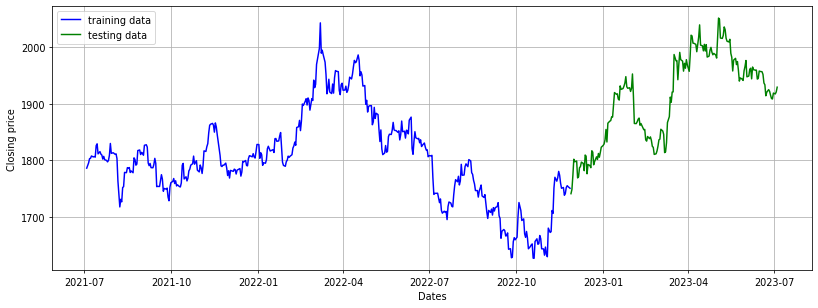

In [16]:
#Plot train and test 
plt.plot(df.index[0:to_row] ,training_data, "blue", label="training data")
plt.plot(df.index[to_row:] ,testing_data, "green", label="testing data")
plt.xlabel("Dates")
plt.ylabel("Closing price")
plt.legend()

In [17]:
#Train ARIMA model

#1.Automatic model
'''
train = df[:to_row]
test = df[to_row:]
model_fit = auto_arima(train, start_p=2, d=None, start_q=2,
                       max_p=5, max_d=2, max_q=5, start_P=1,D=None, 
                       start_Q=1, max_P=2, max_D=1, max_Q=2,trace=True,
                       max_order=5, m=1, seasonal=True,n_fits=50,
                       error_action='warn',  random_state=20,
                       suppress_warnings=True, stepwise=True)


prediction = pd.DataFrame(model_fit.predict(n_periods=len(test)), index=test.index)
prediction.columns = ["predicted_value"]
prediction
'''
#2.Manula model
def create_model(training_data, testing_data, p=4, d=1, q=0):
    #Input p, d, and q parameters to create the ARIMA model and return the ARIMA model 
    #and prediction values (y hat)
    model_prediction = []
    n_tset_obs = len(testing_data)
    for i in range(n_tset_obs):
        model = ARIMA(training_data, order = (p, d, q))#order = (p, d, q)
        model_fit=model.fit()
        output = model_fit.forecast()
        model_prediction.append(list(output))
        actual_test_value = testing_data[i]
        training_data.append(actual_test_value)
    return model_fit, model_prediction

In [18]:
model = create_model(training_data, testing_data, 4, 1, 0)
model[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  621
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -2545.888
Date:                Wed, 12 Jul 2023   AIC                           5101.776
Time:                        13:37:58   BIC                           5123.924
Sample:                             0   HQIC                          5110.385
                                - 621                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0035      0.037     -0.094      0.925      -0.075       0.068
ar.L2         -0.0791      0.038     -2.095      0.036      -0.153      -0.005
ar.L3         -0.0124      0.036     -0.346      0.730      -0.083       0.058
ar.L4          0.0511      0.038      1.330      0.184      -0.024       0.126
sigma2       215.8580      8.964     24.081      0.000     198.289     233.427
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                82.68
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

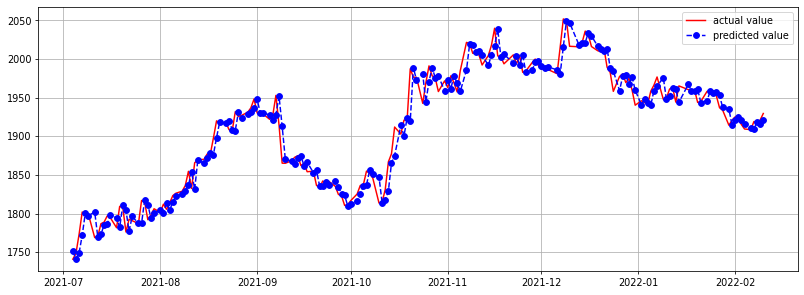

In [19]:
#Visualization
plt.plot(df.index[:len(testing_data)],testing_data, label="actual value", color="red")
plt.plot(df.index[:len(testing_data)],model[1], label="predicted value", marker="o", 
         linestyle = "dashed", color="blue")
plt.legend()

In [20]:
mean_squared_error(testing_data, model[1])

246.98371384437056

In [21]:
mean_absolute_error(testing_data, model[1])

11.29407490455808

In [22]:
mean_absolute_percentage_error(testing_data, model[1])

0.0059027377092010815